# Driver Drowsiness Detection with Convolutional Neural Networks

## Project Overview
This notebook builds and evaluates CNN-based classifiers to detect driver drowsiness using a dataset of driver images. Instead of a single ResNet50 model, we use transfer learning with three architectures and compare them:

- MobileNetV3 (mobilenet_v3_large)
- EfficientNet-B0 (efficientnet_b0)
- SqueezeNet (squeezenet1_0)

All models are adapted for binary classification (Drowsy vs Non Drowsy) by replacing the final classifier layers and fine-tuning the last few layers while freezing the rest.

## Key Steps
- Load dataset and split into train / val / test (≈70% / 20% / 10%).
- Apply transforms and augmentations:
    - Resize to 224×224, optional color jitter, convert to tensor, and normalize with ImageNet mean/std.
- Prepare PyTorch Dataset and DataLoader (batch_size=64).
- Initialize and modify pre-trained models (ImageNet weights when training; loading from .pth for latency measurement).
- Train with cross-entropy loss, Adam optimizer, checkpointing and early stopping.
- Evaluate using accuracy, loss, and confusion matrices; plot training/validation losses.
- Measure and compare inference latency for saved models.

## Notes
- Device detection uses GPU if available.
- Saved best checkpoints are used for final evaluation and latency measurement.
- Visualization includes sample images, confusion matrices, and comparison plots for losses and latency.

## Table of Contents

1. [Installation and Import Libraries](#installation-and-import-libraries)
2. [Data Exploration](#data-exploration)
3. [Dataset Preparation](#dataset-preparation)
4. [Model Architecture](#model-architecture)
5. [Training the Model](#training-the-model)
6. [Evaluating the Model](#evaluating-the-model)
7. [The End](#the-end)

## 1. Installation and Import Libraries

Instructions for setting up the environment and installing dependencies.

In [1]:
#  !pip install torchsummary

In [2]:
import os
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import transforms
from torchvision import  transforms, models
from torchsummary import summary
from PIL import Image 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 2. Data Exploration
explore the dataset to understand its structure and contents. We visualize some sample images and check the distribution of classes in the dataset.


In [3]:
main_path = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'

drowsy_paths = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy_paths = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]

all_dirs = drowsy_paths +  non_drowsy_paths

random.shuffle(all_dirs)

total_size = len(all_dirs)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  

# Split the data
train_paths = all_dirs[:train_size]
val_paths = all_dirs[train_size:train_size + val_size]
test_paths = all_dirs[train_size + val_size:]

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

len_all_dirs = len(all_dirs)
len_train_paths = len(train_paths)
len_val_paths = len(val_paths)
len_test_paths = len(test_paths)

print(f"Total images: {len_all_dirs}")
print(f"Training set: {len_train_paths} images")
print(f"Validation set: {len_val_paths} images")
print(f"Test set: {len_test_paths} images")

Total images: 41793
Training set: 29255 images
Validation set: 8358 images
Test set: 4180 images


In [4]:
def extract_class_name(p):
    return p.split('/')[-2]

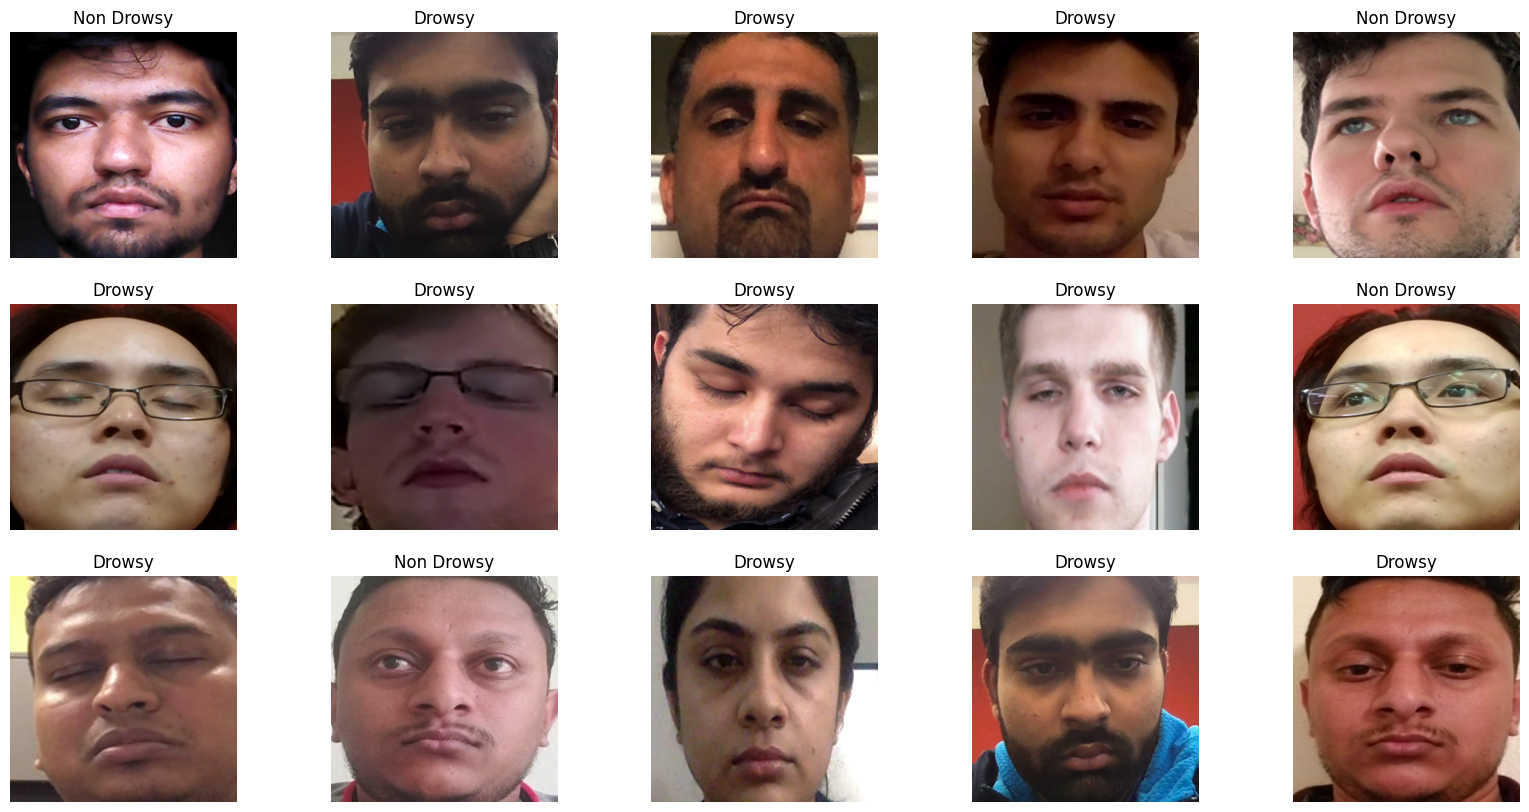

In [5]:
def show_images_with_labels(paths, num_images=15):
    plt.figure(figsize=(20, 10))
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images_with_labels(train_paths, num_images=15)

In [6]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  
device

device(type='cuda', index=0)

## 3. Dataset Preparation
load the dataset, apply transformations, and prepare DataLoaders for training, validation, and testing.

In [7]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = extract_class_name(img_path)

        if self.transform:
            image = self.transform(image)
        
        label = 0 if label == 'Drowsy' else 1

        return image, label

In [8]:
# Define data augmentation and transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),  
#     transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# Define transformations for validation (no augmentation)
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

In [9]:
train_dataset = MyDataset(train_paths, transform=train_transform)
val_dataset = MyDataset(val_paths, transform=test_val_transform)
test_dataset = MyDataset(test_paths, transform=test_val_transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

NameError: name 'MyDataset' is not defined


Training and Evaluating mobilenet


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 125MB/s] 



Model: mobilenet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14 

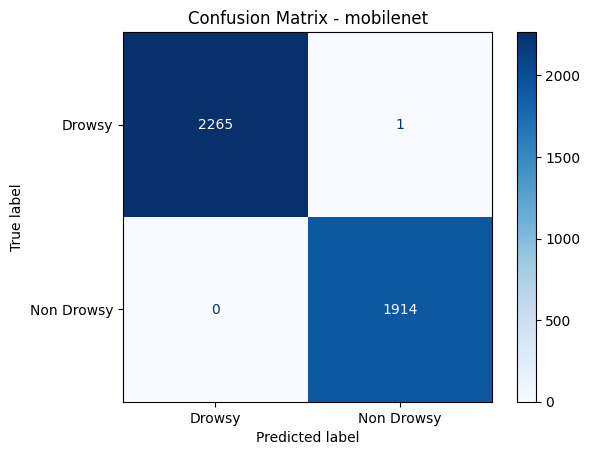

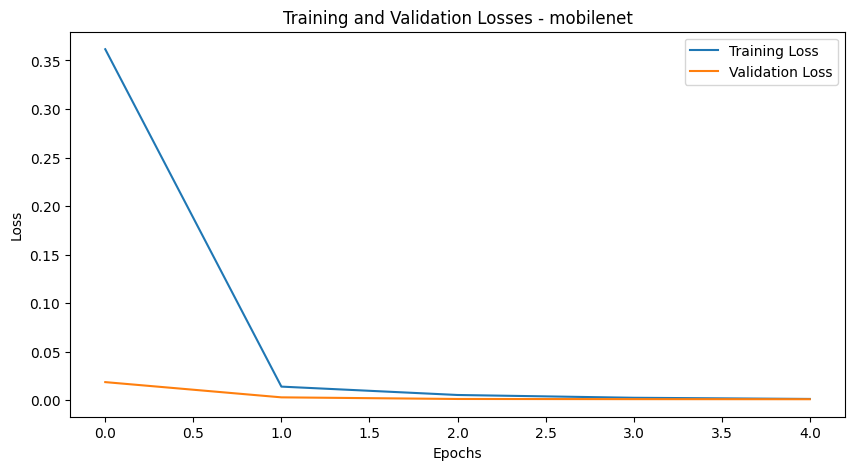

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Training and Evaluating efficientnet


100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]



Model: efficientnet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-

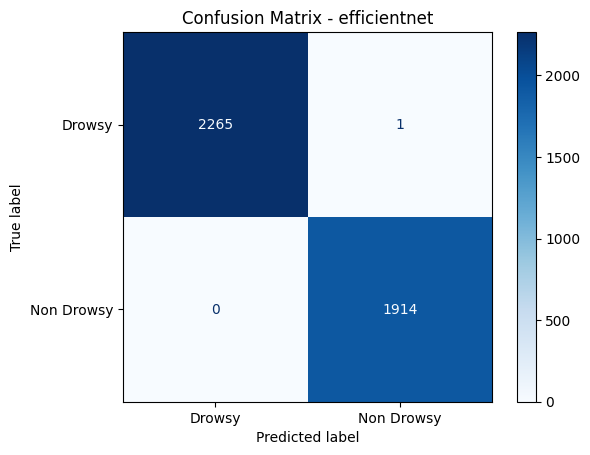

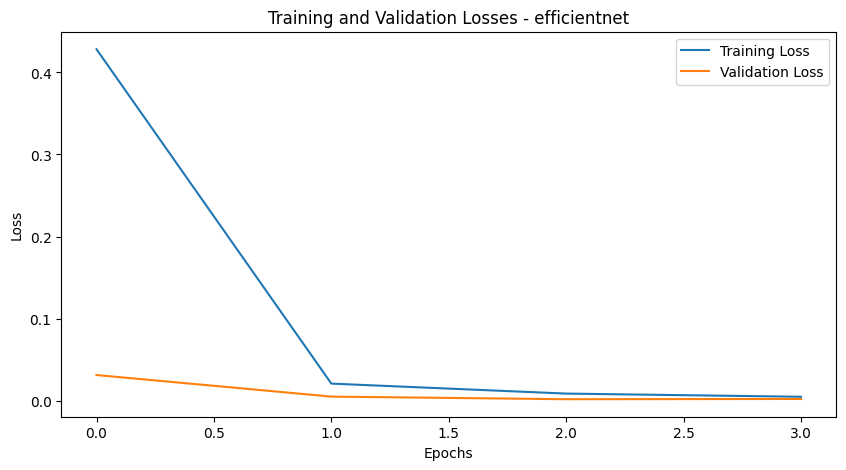

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth



Training and Evaluating squeezenet


100%|██████████| 4.78M/4.78M [00:00<00:00, 62.5MB/s]



Model: squeezenet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14

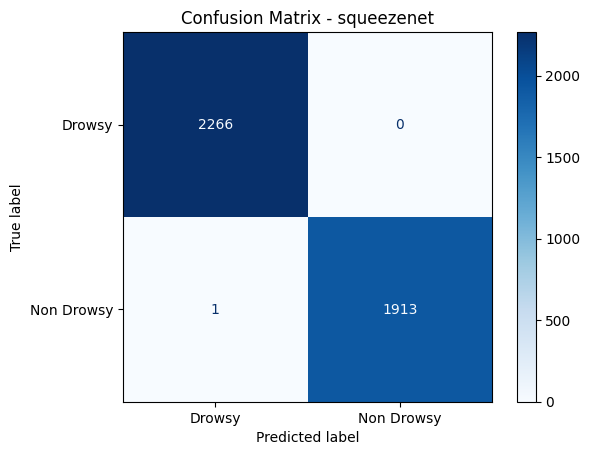

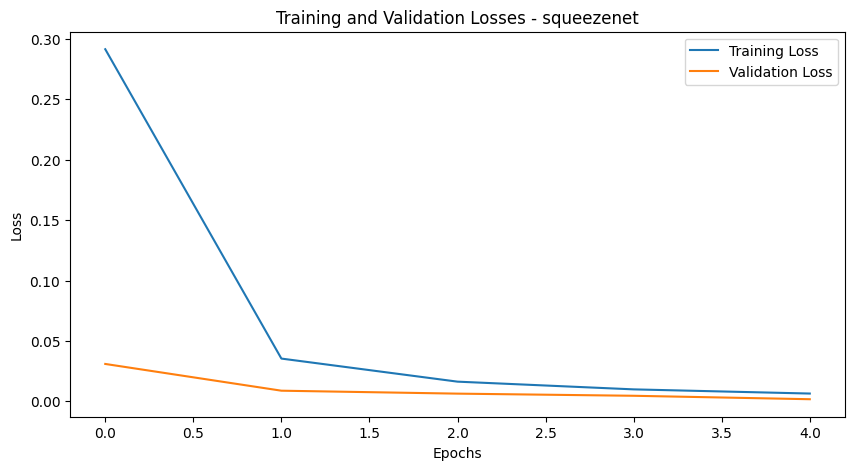


Model Comparison:
          Model Validation Loss Validation Accuracy (%) Test Loss  \
0     mobilenet          0.0011                   99.98    0.0005   
1  efficientnet          0.0017                   99.93    0.0010   
2    squeezenet          0.0017                   99.94    0.0013   

  Test Accuracy (%)  
0             99.98  
1             99.98  
2             99.98  


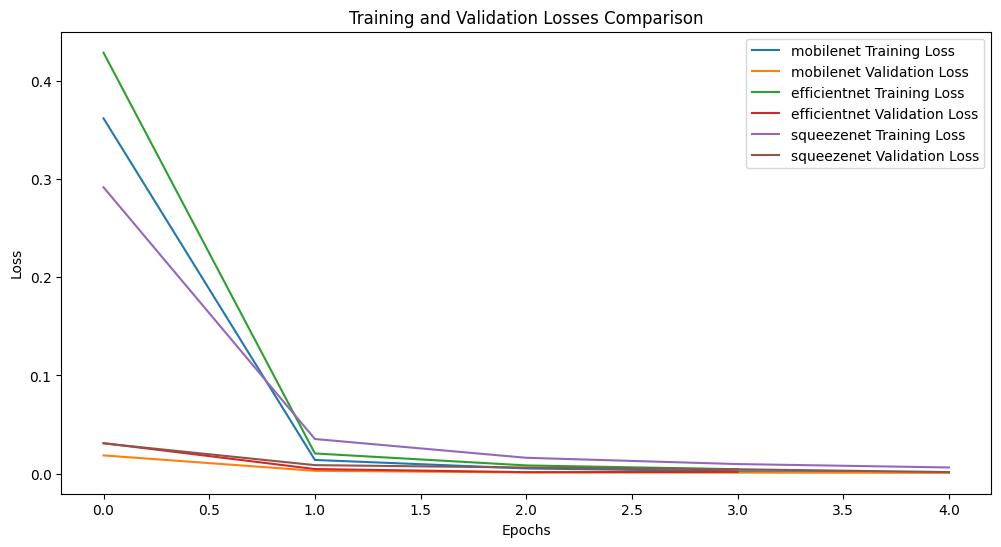

In [25]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os

# Function to initialize the model (MobileNet, EfficientNet, or SqueezeNet)
def initialize_model(model_name, device, n_unfreeze=3):
    if model_name.lower() == "mobilenet":
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
    elif model_name.lower() == "efficientnet":
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    elif model_name.lower() == "squeezenet":
        model = models.squeezenet1_0(weights='IMAGENET1K_V1')
    else:
        raise ValueError("Model must be 'mobilenet', 'efficientnet', or 'squeezenet'")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last n layers
    child_counter = 0
    for child in model.children():
        child_counter += 1
        if child_counter > len(list(model.children())) - n_unfreeze:
            for param in child.parameters():
                param.requires_grad = True

    # Replace the classifier
    if model_name.lower() == "mobilenet":
        num_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
    elif model_name.lower() == "efficientnet":
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
    elif model_name.lower() == "squeezenet":
        num_features = 512  # SqueezeNet has 512 features before the final classifier
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(num_features, 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    # Move model to device
    model = model.to(device)
    return model

# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0 or (i+1) == len(train_loader):
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Train Loss: {running_loss / (i+1):.4f}')
    
    avg_loss = running_loss / total_step
    return avg_loss

# Evaluation function
def evaluate_model(model, data_loader, criterion, device, dataset_type='Validation'):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = len(data_loader.dataset)
        total_loss = 0 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels) 
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
        print(f'{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}')
        return avg_loss, accuracy 

# Checkpointing and early stopping
def checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter, path):
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        os.makedirs(os.path.dirname(path), exist_ok=True)  # Ensure directory exists
        torch.save(model.state_dict(), path)
        print(f"New best model saved with validation loss: {avg_val_loss:.4f} at {path}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            return True, best_val_loss, counter
    return False, best_val_loss, counter

# Load the best model
def load_best_model(model, path):
    model.load_state_dict(torch.load(path))
    print("Best model loaded from", path)

# Confusion matrix evaluation
def evaluate_and_confusion_matrix(model, test_loader, criterion, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    return cm

# Main training and evaluation loop for a single model
def train_and_evaluate_model(model_name, train_loader, val_loader, test_loader, device):
    # Initialize model
    model = initialize_model(model_name, device)
    
    # Print model summary
    print(f"\nModel: {model_name}")
    summary(model, (3, 224, 224))

    # Training parameters
    num_epochs = 5
    patience = 1
    best_val_loss = float('inf')
    counter = 0
    learning_rate = 0.00001
    train_losses = []
    val_losses = []

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step)
        train_losses.append(avg_train_loss)
        
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)
        
        early_stop, best_val_loss, counter = checkpoint_and_early_stopping(
            avg_val_loss, 
            model, 
            best_val_loss, 
            patience, 
            counter, 
            path=f'/kaggle/working/best_{model_name}_model.pth'
        )
        if early_stop:
            break
        
        print('##' * 20)

    # Load the best model checkpoint
    load_best_model(model, path=f'/kaggle/working/best_{model_name}_model.pth')

    # Evaluate on validation and test sets
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device, dataset_type='Test')

    # Plot confusion matrix
    cm = evaluate_and_confusion_matrix(model, test_loader, criterion, device, model_name)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Losses - {model_name}')
    plt.show()

    return {
        'model_name': model_name,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'confusion_matrix': cm
    }

# Compare results of all models
def compare_models(results):
    # Create a DataFrame for comparison
    comparison_data = {
        'Model': [r['model_name'] for r in results],
        'Validation Loss': [f"{r['val_loss']:.4f}" for r in results],
        'Validation Accuracy (%)': [f"{r['val_accuracy']:.2f}" for r in results],
        'Test Loss': [f"{r['test_loss']:.4f}" for r in results],
        'Test Accuracy (%)': [f"{r['test_accuracy']:.2f}" for r in results]
    }
    df = pd.DataFrame(comparison_data)
    print("\nModel Comparison:")
    print(df)

    # Plot combined training and validation losses
    plt.figure(figsize=(12, 6))
    for result in results:
        plt.plot(result['train_losses'], label=f"{result['model_name']} Training Loss")
        plt.plot(result['val_losses'], label=f"{result['model_name']} Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses Comparison')
    plt.show()

# Main function to run all models and compare
def train_and_compare(train_loader, val_loader, test_loader, device):
    model_names = ['mobilenet', 'efficientnet', 'squeezenet']  # Added squeezenet
    results = []

    for model_name in model_names:
        print(f"\n{'='*40}\nTraining and Evaluating {model_name}\n{'='*40}")
        result = train_and_evaluate_model(model_name, train_loader, val_loader, test_loader, device)
        results.append(result)

    compare_models(results)

# Example usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_and_compare(train_loader, val_loader, test_loader, device)


Measuring Latency for mobilenet
Loaded mobilenet model from /kaggle/input/kantuk/pytorch/default/1/best_mobilenet_model.pth
mobilenet Average Latency: 6.4107 ms

Measuring Latency for efficientnet
Loaded efficientnet model from /kaggle/input/kantuk/pytorch/default/1/best_efficientnet_model.pth
efficientnet Average Latency: 8.4015 ms

Measuring Latency for squeezenet
Loaded squeezenet model from /kaggle/input/kantuk/pytorch/default/1/best_squeezenet_model.pth
squeezenet Average Latency: 2.0428 ms

Latency Comparison:
          Model Latency (ms)
0     mobilenet       6.4107
1  efficientnet       8.4015
2    squeezenet       2.0428


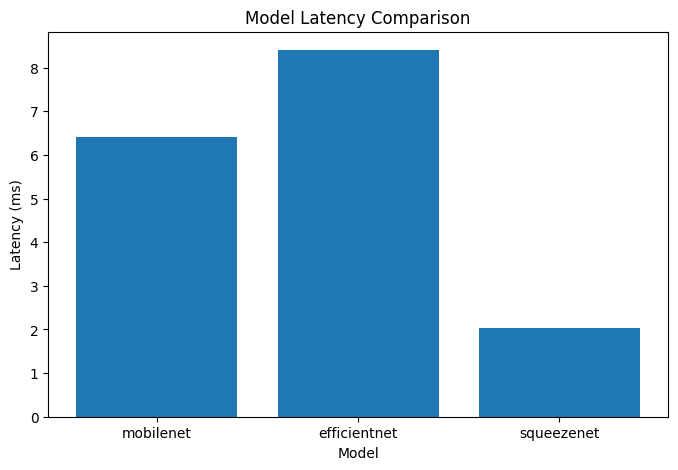

In [11]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models
import os

# Function to initialize the model (MobileNet, EfficientNet, or SqueezeNet)
def initialize_model(model_name, device, n_unfreeze=3):
    if model_name.lower() == "mobilenet":
        model = models.mobilenet_v3_large(weights=None)
    elif model_name.lower() == "efficientnet":
        model = models.efficientnet_b0(weights=None)
    elif model_name.lower() == "squeezenet":
        model = models.squeezenet1_0(weights=None)
    else:
        raise ValueError("Model must be 'mobilenet', 'efficientnet', or 'squeezenet'")

    # Replace the classifier to match training configuration
    if model_name.lower() == "mobilenet":
        num_features = model.classifier[0].in_features
        model.classifier = torch.nn.Sequential(
            torch.nn.Linear(num_features, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 2)
        )
    elif model_name.lower() == "efficientnet":
        num_features = model.classifier[1].in_features
        model.classifier = torch.nn.Sequential(
            torch.nn.Linear(num_features, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 2)
        )
    elif model_name.lower() == "squeezenet":
        num_features = 512
        model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(num_features, 2, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten()
        )

    # Move model to device
    model = model.to(device)
    return model

# Function to measure latency of a model
def measure_latency(model, device, input_size=(1, 3, 224, 224), num_runs=100):
    model.eval()
    # Create a dummy input
    input_tensor = torch.randn(input_size).to(device)
    
    # Warm-up run
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)
    
    # Measure latency
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs * 1000  # Convert to milliseconds
    return avg_latency

# Function to load model and measure latency
def evaluate_model_latency(model_name, model_path, device):
    # Initialize model
    model = initialize_model(model_name, device)
    
    # Load model weights
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded {model_name} model from {model_path}")
    else:
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    # Measure latency
    latency = measure_latency(model, device)
    print(f"{model_name} Average Latency: {latency:.4f} ms")
    
    return {
        'model_name': model_name,
        'latency_ms': latency
    }

# Function to compare latency across models
def compare_latency(results):
    # Create a DataFrame for comparison
    comparison_data = {
        'Model': [r['model_name'] for r in results],
        'Latency (ms)': [f"{r['latency_ms']:.4f}" for r in results]
    }
    df = pd.DataFrame(comparison_data)
    print("\nLatency Comparison:")
    print(df)
    
    # Plot latency comparison
    plt.figure(figsize=(8, 5))
    plt.bar([r['model_name'] for r in results], [r['latency_ms'] for r in results])
    plt.xlabel('Model')
    plt.ylabel('Latency (ms)')
    plt.title('Model Latency Comparison')
    plt.show()

# Main function to measure and compare latency
def measure_and_compare_latency(model_paths, device):
    results = []
    for model_name, model_path in model_paths.items():
        print(f"\n{'='*40}\nMeasuring Latency for {model_name}\n{'='*40}")
        result = evaluate_model_latency(model_name, model_path, device)
        results.append(result)
    
    compare_latency(results)

# Example usage
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Dictionary of model names and their corresponding .pth file paths
    model_paths = {
        'mobilenet': '/kaggle/input/kantuk/pytorch/default/1/best_mobilenet_model.pth',
        'efficientnet': '/kaggle/input/kantuk/pytorch/default/1/best_efficientnet_model.pth',
        'squeezenet': '/kaggle/input/kantuk/pytorch/default/1/best_squeezenet_model.pth'
    }
    
    measure_and_compare_latency(model_paths, device)